In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot 
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(180),
    transforms.CenterCrop(180),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #These are the commonly used ImageNet values
])

testing_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.CenterCrop(180),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])

In [3]:
path = 'Data/'
training_data = datasets.ImageFolder(str(path+'train'),transform=training_transform)
testing_data = datasets.ImageFolder(str(path+'test'),transform=testing_transform)

torch.manual_seed(13)
training_loader = DataLoader(training_data,batch_size=10,shuffle=True)
testing_loader = DataLoader(testing_data,batch_size=10)

class_names = training_data.classes

In [4]:
print(class_names)

['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [4]:
print('Training Data: ',len(training_data))
print('Testing Data: ',len(testing_data))

Training Data:  900
Testing Data:  40


In [5]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(43*43*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,6)
        
    def forward(self, X):
        X = Func.relu(self.conv1(X))
        X = Func.max_pool2d(X,2,2)
        X = Func.relu(self.conv2(X))
        X = Func.max_pool2d(X,2,2)
        X = X.view(-1,43*43*16)
        X = Func.relu(self.fc1(X))
        X = Func.relu(self.fc2(X))
        X = self.fc3(X)
        
        return Func.log_softmax(X,dim=1)

In [6]:
torch.manual_seed(13)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.00005)

In [7]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=29584, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [8]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
3550080
120
10080
84
504
6


In [9]:
import time
start_time = time.time()

epochs = 5


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(training_loader): #b is batches
        
        b+=1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        #Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update Parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%20 == 0:
            print(f'Epoch {i} LOSS: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # TEST SET!
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(testing_loader):
            
            y_val = CNNmodel(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Total time: {total_time/60} minutes')

Epoch 0 LOSS: 1.715682029724121
Epoch 0 LOSS: 1.7383887767791748
Epoch 0 LOSS: 1.7542102336883545
Epoch 0 LOSS: 1.8349567651748657
Epoch 1 LOSS: 1.4178860187530518
Epoch 1 LOSS: 1.604825735092163
Epoch 1 LOSS: 1.5007013082504272
Epoch 1 LOSS: 1.7350858449935913
Epoch 2 LOSS: 1.6970312595367432
Epoch 2 LOSS: 1.4483081102371216
Epoch 2 LOSS: 1.5645320415496826
Epoch 2 LOSS: 1.5296276807785034
Epoch 3 LOSS: 1.5117601156234741
Epoch 3 LOSS: 1.6477117538452148
Epoch 3 LOSS: 1.3955777883529663
Epoch 3 LOSS: 1.7163728475570679
Epoch 4 LOSS: 1.2133591175079346
Epoch 4 LOSS: 1.4842888116836548
Epoch 4 LOSS: 1.2278815507888794
Epoch 4 LOSS: 1.2336980104446411
Total time: 0.4539473533630371 minutes


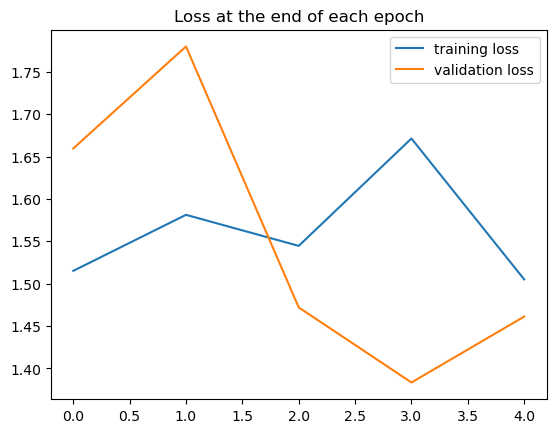

In [10]:
with torch.no_grad():
    plot.plot(train_losses, label='training loss')
    plot.plot(test_losses, label='validation loss')
    plot.title('Loss at the end of each epoch')
    plot.legend();

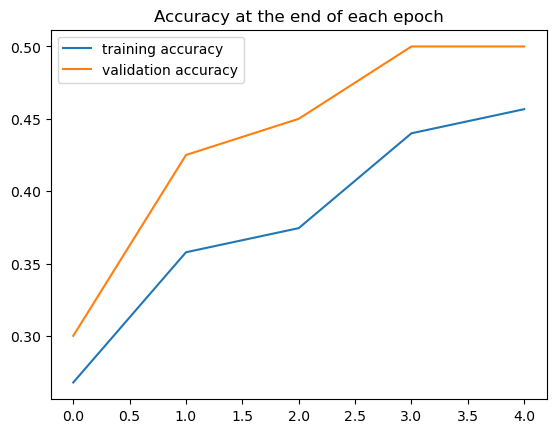

In [11]:
with torch.no_grad():
    plot.plot([t/900 for t in train_correct], label='training accuracy')
    plot.plot([t/40 for t in test_correct], label='validation accuracy')
    plot.title('Accuracy at the end of each epoch')
    plot.legend();

In [12]:
for i in range(len(test_correct)):
    print(f'Test {i+1} accuracy: {test_correct[i].item()*100/40:.3f}%')

Test 1 accuracy: 30.000%
Test 2 accuracy: 42.500%
Test 3 accuracy: 45.000%
Test 4 accuracy: 50.000%
Test 5 accuracy: 50.000%


Label: [5 3 2 5 2 4 2 2 5 5]
Class: mauve_stinger_jellyfish compass_jellyfish blue_jellyfish mauve_stinger_jellyfish blue_jellyfish lions_mane_jellyfish blue_jellyfish blue_jellyfish mauve_stinger_jellyfish mauve_stinger_jellyfish


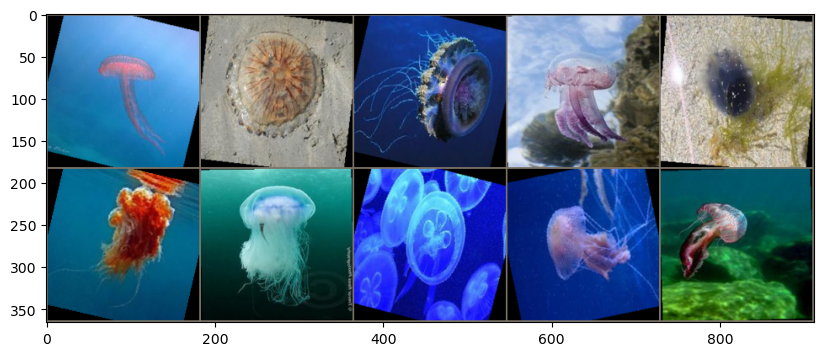

In [15]:
# Grab the first batch of 10 images
for images,labels in training_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plot.figure(figsize=(12,4))
plot.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));